In [2]:
#import library
from scipy.stats import norm
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
import scipy.stats as st
from mpl_toolkits.mplot3d import Axes3D
import math
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
%matplotlib inline

Define the prior by multuvatiate distribution

In [3]:
mu_1= [0.,0.]

cov_1 = [[ 1,  0.],
        [ 0.,  1]]


In [4]:
## initial the model

c = 0 # mean of observations
N = 100 # number of observation data
sigma2y = 1 # standard deviation of observation data
## generate the observation data
np.random.seed(121)
y_ = np.random.normal(loc =c, scale = sigma2y, size = N)
D = tf.convert_to_tensor(y_,dtype = tf.float32)

np.random.seed(121)
## define the log probability

@tf.function
def joint_log_post(D,theta1,theta2):
    # define random variables prior
    mvn = tfd.MultivariateNormalTriL(
            loc = mu_1,
            scale_tril=tf.linalg.cholesky(cov_1))
    z = tf.stack([theta1, theta2], axis=-1)
    # define likelihood
    y = tfd.Normal(loc = tf.add(theta2,tf.pow(theta1,2.)), scale = sigma2y)
    # return the posterior probability
    return(mvn.log_prob(tf.squeeze(z))
          +tf.reduce_sum(y.log_prob(D)))

In [5]:
x_1, y_1 = np.mgrid[-2:2:.03, -2:2:.03]
pos = np.empty(x_1.shape + (2,),dtype = np.float32) 
pos[:, :, 0] = x_1; pos[:, :, 1] = y_1
pos = tf.convert_to_tensor(pos)

def full_post():
    post = np.empty(x_1.shape)
    for i in range(np.arange(-2,2,.03).shape[0]):
        for j in range(np.arange(-2,2,.03).shape[0]):
            post[i][j] = joint_log_post(D,pos[i][j][0],pos[i][j][1])
    return post

post =  full_post()

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [7]:
print('x:',x_1[np.unravel_index(np.argmax(post),post.shape)])
print('y',y_1[np.unravel_index(np.argmax(post),post.shape)])

x: 0.009999999999999787
y 0.040000000000000036


In [8]:
np.unravel_index(np.argmax(post),post.shape)

(67, 68)

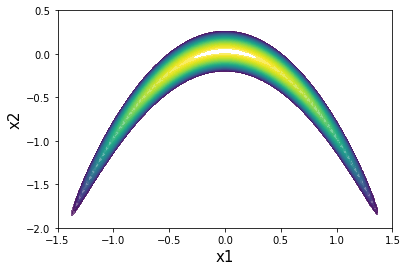

In [9]:
# levels = np.arange(joint_log_post(D,-0.,-0.2), joint_log_post(D,-0.,-0.0), 
#                    (joint_log_post(D,-0.,-0.0)- joint_log_post(D,-0.,-0.2))/20)
levels = np.arange(joint_log_post(D,-0.,-0.2), joint_log_post(D,0.0099,0.04), 
                   (joint_log_post(D,0.0099,0.04)- joint_log_post(D,-0.,-0.2))/50)

def draw_post():
#     plt.contourf(x_1, y_1, post,[joint_log_post(D,-0.,-0.13)])
    plt.contourf(x_1, y_1, post,levels = levels,alpha = 0.7)

    plt.xlim(-1.5,1.5)
    plt.ylim(-2,0.5)
    plt.xlabel("x1",fontsize = 15)
    plt.ylabel("x2",fontsize = 15)
draw_post()

##TODO modify the color map

## <b>RMH

Adjust the step size

In [10]:
num_results = 500
burnin = 100

initial_chain_state = [
    -1.7 * tf.ones([], dtype=tf.float32, name="init_t1"),
    -1.5 * tf.ones([], dtype=tf.float32, name="init_t2")
]

dtype = np.float32

@tf.function
def unnormalized_posterior_log_prob(*args):
    return joint_log_post(D,*args)

# adjust the step size of Random walk Matroplis Hasting MCMC
def gauss_new_state_fn(scale, dtype):
  gauss = tfd.Normal(loc=dtype(0), scale=dtype(scale))
  def _fn(state_parts, seed):
    next_state_parts = []
    seed_stream  = tfp.util.SeedStream(seed, salt='RandomNormal')
    for sp in state_parts:
      next_state_parts.append(sp + gauss.sample(
        sample_shape=sp.shape, seed=seed_stream()))
    return next_state_parts
  return _fn

@tf.function
def run_chain_RWMC(scale):
    samples, kernel_results= tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=burnin,
        current_state=initial_chain_state,
        kernel=tfp.mcmc.RandomWalkMetropolis(
            target_log_prob_fn=unnormalized_posterior_log_prob,
            new_state_fn=gauss_new_state_fn(scale=scale, dtype=dtype),
            seed=42))  # For determinism.
    return samples,kernel_results

samples,kernel_results = run_chain_RWMC(0.1)

samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

x1 = samples[:,0]
y1 = samples[:,1]

x_accepted = []
y_accepted =[]

/Users/zhouji/anaconda3/envs/bys/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


Acceptance rate: 59.0%


/Users/zhouji/anaconda3/envs/bys/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


Acceptance rate: 40.2%


/Users/zhouji/anaconda3/envs/bys/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


Acceptance rate: 29.2%


/Users/zhouji/anaconda3/envs/bys/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


Acceptance rate: 23.2%


/Users/zhouji/anaconda3/envs/bys/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


Acceptance rate: 14.0%


/Users/zhouji/anaconda3/envs/bys/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


Acceptance rate: 14.0%


/Users/zhouji/anaconda3/envs/bys/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


Acceptance rate: 11.8%


/Users/zhouji/anaconda3/envs/bys/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


Acceptance rate: 9.2%


/Users/zhouji/anaconda3/envs/bys/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


Acceptance rate: 8.6%


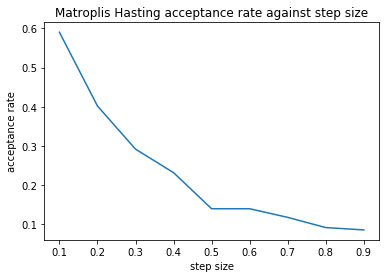

In [11]:
acc = []
for scale in np.arange(0.1,1,0.1):
    _,kernel_results_ = run_chain_RWMC(scale)
    accepted_ = kernel_results_.is_accepted
    print('Acceptance rate: %0.1f%%' % (100*tf.reduce_mean(tf.cast(accepted_, dtype=tf.float32))))
    acc.append(tf.reduce_mean(tf.cast(accepted_, dtype=tf.float32)))
plt.title('Matroplis Hasting acceptance rate against step size')
plt.ylabel('acceptance rate')
plt.xlabel('step size')
plt.plot(np.arange(0.1,1,0.1),acc)
plt.savefig('/Users/zhouji/Documents/Results/Banana/Randomw_walk_step.png')

Acceptance rate: 54.6%


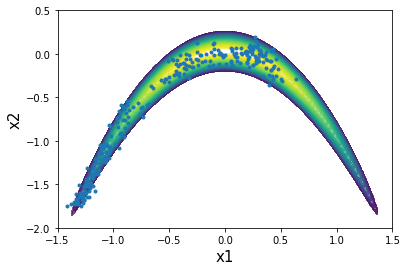

In [12]:
x_accepted_RW = samples[np.where(accepted ==True)][:,0]
y_accepted_RW = samples[np.where(accepted ==True)][:,1]

plt.plot(x_accepted_RW,y_accepted_RW,'.')
# plot_true()

print('Acceptance rate: %0.1f%%' % (100*(x_accepted_RW.shape[0]/num_results)))
draw_post()

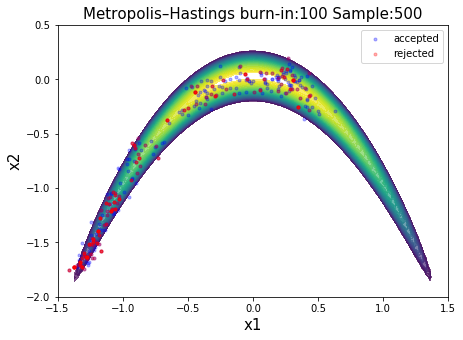

In [13]:
plt.figure(figsize=(7,5))
draw_post()
x_accepted_RW = samples[np.where(accepted ==True)][:,0]
y_accepted_RW = samples[np.where(accepted ==True)][:,1]
x_rejected_RW = samples[np.where(accepted ==False)][:,0]
y_rejected_RW = samples[np.where(accepted ==False)][:,1]

plt.xlim(-1.5,1.5)
plt.ylim(-2,0.5)
plt.title('Metropolis–Hastings burn-in:100 Sample:500',fontsize = 15)
plt.plot(x_accepted_RW,y_accepted_RW,'b.',label = 'accepted',alpha = 0.3)
plt.plot(x_rejected_RW,y_rejected_RW,'r.',label = 'rejected',alpha = 0.3)
        
plt.legend(loc = 'upper right')
plt.savefig('/Users/zhouji/Documents/Results/Banana/Banana_randomwalk.png')

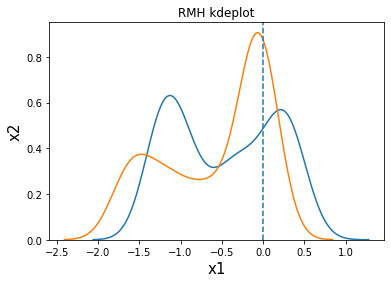

In [40]:
sns.kdeplot(x_accepted_RW)
sns.kdeplot(y_accepted_RW)

plt.xlabel("x1",fontsize = 15)
plt.ylabel("x2",fontsize = 15)
plt.title('RMH kdeplot')
plt.axvline(x=0, linestyle='--')
plt.savefig('/Users/zhouji/Documents/Results/Banana/kde_RMH.png')

<b> HMC

In [43]:
@tf.function
def run_HMC():
    samples, kernel_results = tfp.mcmc.sample_chain(
        num_results=num_results,
        current_state=initial_chain_state,
        kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_posterior_log_prob,
            step_size = 0.02,
            num_leapfrog_steps = 3),
        num_burnin_steps=burnin,
        num_steps_between_results=1,  # Thinning.
        parallel_iterations=1)
    return samples,kernel_results

samples,kernel_results = run_HMC()

samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

x1 = samples[:,0]
y1 = samples[:,1]

x_accepted = []
y_accepted =[]

/Users/zhouji/anaconda3/envs/bys/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


Acceptance rate: 98.4%


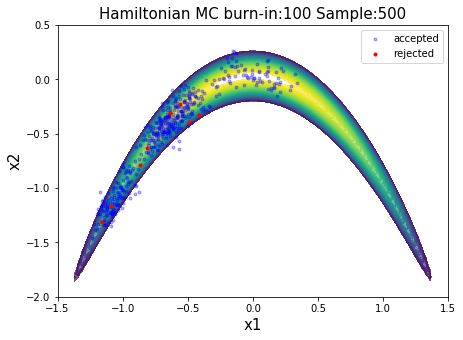

In [45]:
plt.figure(figsize=(7,5))
draw_post()
x_accepted = samples[np.where(accepted ==True)][:,0]
y_accepted = samples[np.where(accepted ==True)][:,1]
x_rejected = samples[np.where(accepted ==False)][:,0]
y_rejected = samples[np.where(accepted ==False)][:,1]

plt.xlim(-1.5,1.5)
plt.ylim(-2,0.5)
plt.title('Hamiltonian MC burn-in:100 Sample:500',fontsize = 15)
plt.plot(x_accepted,y_accepted,'b.',label = 'accepted',alpha = 0.3)
plt.plot(x_rejected,y_rejected,'r.',label = 'rejected',alpha = 1)
        
plt.legend(loc = 'upper right')
print('Acceptance rate: %0.1f%%' % (100*(x_accepted.shape[0]/num_results)))
plt.savefig('/Users/zhouji/Documents/Results/Banana/Banana_HMC.png')

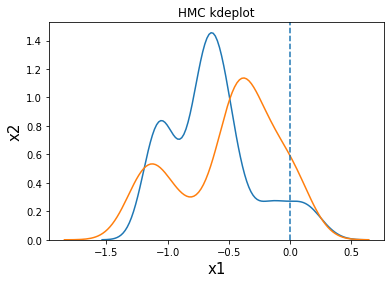

In [46]:
sns.kdeplot(x_accepted)
sns.kdeplot(y_accepted)

plt.xlabel("x1",fontsize = 15)
plt.ylabel("x2",fontsize = 15)
plt.title('HMC kdeplot')
plt.axvline(x=0, linestyle='--')
plt.savefig('/Users/zhouji/Documents/Results/Banana/kde_HMC.png')

<b> Hessian MCMC - banana v1.0

Set up the target probability density

<b> Gradient Descent

In [19]:
## Block out in case run by accident, takes too long to run 28 min
steps = 10000
@tf.function()
def gradient_decent():
    mu = tf.constant([-0.1, -0.])
    for i in tf.range(steps):
        with tf.GradientTape() as t:  
            t.watch(mu)
            theta1 = mu[0]
            theta2 = mu[1]
            loss = tf.negative(joint_log_post(D,theta1,theta2))
            dlossdmu = t.gradient(loss,mu)
            mu = mu - 0.001*dlossdmu
    return mu


Let's take (0,0) as MAP for now

In [20]:
MAP = gradient_decent()

A new hessian function 2019-11-27

In [21]:
@tf.function
def Full_Hessian():
    Hess = tf.TensorArray(tf.float32, size=2)
    j=0
    for i in range(2):
        with tf.GradientTape() as t:
            t.watch(MAP)
            with tf.GradientTape() as tt:
                tt.watch(MAP)
                loss = -joint_log_post(D,MAP[0],MAP[1])
            jac = tt.gradient(loss,MAP,unconnected_gradients='zero')[i]
        hess = t.gradient(jac,MAP,unconnected_gradients = 'none')
        Hess = Hess.write(j,hess)
        j = j+1
    return Hess.stack()

New_Hessian = Full_Hessian()

#### Compute the Hessian and Covariance of the Posterior at MAP

Laplace approximation

\begin{equation}
\mathcal{C}_{\mathrm{post}}=\left(\mathcal{H}_{\mathrm{misfit}}\left(m_{\nu}\right)+\mathcal{C}_{\mathrm{prior}}^{-1}\right)^{-1}
\end{equation}

In [22]:
cov= [[1.,0.],[0.,1.]]
cov = tf.convert_to_tensor(cov,dtype = tf.float32)
tf.linalg.inv(cov)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 0.],
       [0., 1.]], dtype=float32)>

In [23]:
# C_post = [[5.3157514e-01, 2.5224808e-04],
#        [2.5224808e-04, 9.8040411e-03]]

In [24]:
Sum = 0
Sum = tf.add(New_Hessian,tf.linalg.inv(cov))
C_post = tf.linalg.inv(Sum)
C_post

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[5.1596260e-01, 8.9229425e-06],
       [8.9229416e-06, 9.8039219e-03]], dtype=float32)>

Text(0, 0.5, 'x2')

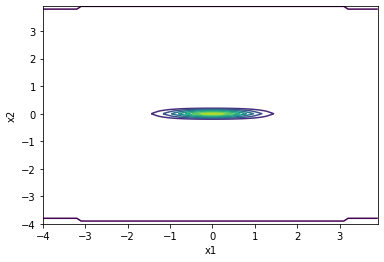

In [25]:
from scipy.stats import multivariate_normal
loc  = [0.,0.]
cov = C_post
x, y = np.mgrid[-4:4:.1, -4:4:.1]
pos = np.empty(x.shape + (2,)) 
pos[:, :, 0] = x; pos[:, :, 1] = y
rv = multivariate_normal(loc, cov)
plt.contour(x, y, rv.pdf(pos))
plt.xlabel("x1")
plt.ylabel("x2")

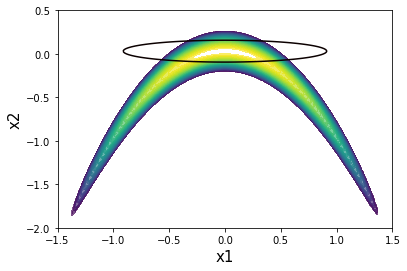

In [26]:

def plot_dist(loc,cov):
    x, y = np.mgrid[-4:4:.01, -4:4:.01]
    pos = np.empty(x.shape + (2,)) 
    pos[:, :, 0] = x; pos[:, :, 1] = y
    rv = multivariate_normal(loc, cov)
#     plt.contour(x, y, rv.pdf(pos),np.arange(0.00001,0.0007,0.0001))
    plt.contour(x, y, rv.pdf(pos),[1.,3,10.], cmap=plt.get_cmap('hot'))
    plt.xlabel("x1")
    plt.ylabel("x2")
plot_dist(MAP,C_post)

draw_post() 

# plt.savefig('/Users/zhouji/Documents/IRTG 2019/Presentation/Input/hess_banana.png')

#### Define whether to accept or reject the new sample
\begin{equation}
\Phi\left(m, \mathbf{d}_{\mathrm{obs}}\right)=\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\mathrm{obs}}\right\|_{\Gamma_{\mathrm{noise}}^{-1}}
\end{equation}


gpCN is a generalized version of the pCN sampler. While the proposals of pCN are drown from the prior Gaussian distribution $\mu_{prior}$,proposals in the generalized pCN are drown from a Gaussian approximation $v$ of the posterior distribution.

\begin{equation}
a_{\nu}\left(m_{\mathrm{current}}, m_{\mathrm{proposed}}\right) :=\min \left\{1, \exp \left(\Delta\left(m_{\mathrm{current}}\right)-\Delta\left(m_{\mathrm{proposed}}\right)\right)\right\}
\end{equation}

where   

\begin{equation}
\Delta(m)=\Phi\left(m, \mathbf{d}_{\mathrm{obs}}\right)+\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\mathrm{prior}}\right\|_{C_{\mathrm{prior}}^{-1}}^{2}-\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\nu}\right\|_{\mathrm{C}_{\nu}^{-1}}^{2}
\end{equation}

$\Phi\left(m, \mathbf{d}_{\mathrm{obs}}\right)+\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\mathrm{prior}}\right\|_{C_{\mathrm{prior}}^{-1}}^{2}$  is the negative log posterior

In [27]:
@tf.function
def matrixcompute(matrix1,matrix2,Cov):
    matrix1 = tf.cast(matrix1,tf.float32)
    matrix2 = tf.cast(matrix2,tf.float32)
    matrix = tf.subtract(matrix1, matrix2)
    matrix = tf.reshape(matrix,[matrix.shape[0],1])
    matrix_T = tf.transpose(matrix)
    Cov_inv = tf.linalg.inv(Cov)
    result = tf.multiply(tf.constant(1/2),tf.matmul(tf.matmul(matrix_T,Cov_inv),matrix))
    return result

In [28]:
@tf.function
def negative_log_post(vars):
    return(tf.negative(joint_log_post(D,vars[0],vars[1])))
@tf.function
def acceptance_gpCN(m_current , m_proposed):
    delta_current = tf.add(negative_log_post(m_current),matrixcompute(m_current,MAP,C_post))
    delta_proposed = tf.add(negative_log_post(m_proposed),matrixcompute(m_proposed,MAP,C_post))

    ## calculate accept ratio if exp()<1
    accept_ratio = tf.exp(tf.subtract(delta_current,delta_proposed))
    acceptsample = tfd.Sample(
    tfd.Uniform(0., 1.),
    sample_shape=[1,1])
    sample = acceptsample.sample()
    
    if(accept_ratio > sample):
        return True
    else:
        return False
        

In [48]:
from IPython.display import clear_output
# define leaning rate
beta = tf.constant(0.25)

@tf.function
def draw_proposal(m_current):
    
    _term1 = MAP
    
    ## sqrt term
    tem_1 = tf.convert_to_tensor(tf.sqrt(1-beta**2),dtype = tf.float32)
    ## sqrt(1-beta^2)()
    _term2 = tf.multiply(tem_1,(tf.subtract(m_current,MAP)))
    
    Xi = tfd.MultivariateNormalFullCovariance(
            loc = 0,
            covariance_matrix= C_post)

    Xi_s = tfd.Sample(Xi)
    _term3 = tf.multiply(beta,Xi_s.sample())
    
    m_proposed = tf.add(MAP,tf.add(_term2,_term3))
    
    return m_proposed

In [49]:
mu_init = [-1.7,-1.5]

In [50]:
number_of_steps = 500

def run_chain():
    burn_in = 100
    steps = number_of_steps
    k = 0
    accepted = []
    rejected = []

    m_current = mu_init  # init m
    
    
    for k in range(steps+burn_in):

        m_proposed = draw_proposal(m_current)

        if acceptance_gpCN(m_current,m_proposed):
            m_current = m_proposed
            if k > burn_in:
                accepted.append(m_proposed.numpy())
        else:
            m_current = m_current
            rejected.append(m_proposed.numpy())
    
    return accepted,rejected

accepted,rejected = run_chain()

print('acceptance rate = %0.1f%%' % (100*np.shape(accepted)[0]/number_of_steps))

accepted = np.array(accepted)



acceptance rate = 73.0%


In [51]:
# for beta in np.arange(0.1,1,0.01):
#     accepted,rejected = run_chain()
#     print(beta)
#     print('acceptance rate = %0.1f%%' % (100*np.shape(accepted)[0]/number_of_steps))
#     accepted = np.array(accepted)

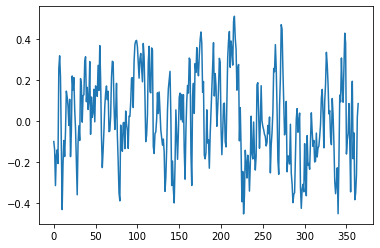

In [52]:
plt.plot(accepted[:,0])

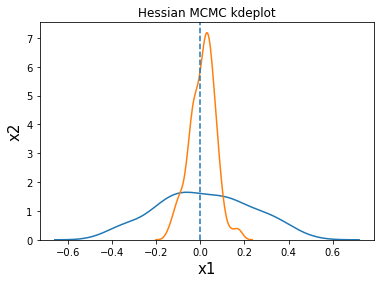

In [55]:
sns.kdeplot(accepted[:,0])
sns.kdeplot(accepted[:,1])

plt.xlabel("x1",fontsize = 15)
plt.ylabel("x2",fontsize = 15)
plt.title('Hessian MCMC kdeplot')
plt.axvline(x=0, linestyle='--')
plt.savefig('/Users/zhouji/Documents/Results/Banana/kde_Hess.png')

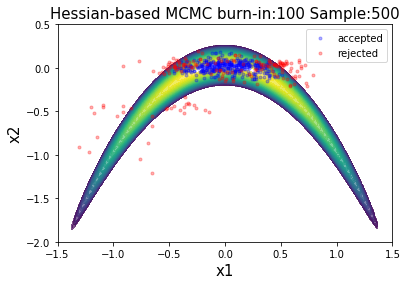

In [56]:
# sns.kdeplot(x_accepted,y_accepted,ax=ax1)
accepted = np.array(accepted)
rejected = np.array(rejected)

plt.title('Hessian-based MCMC burn-in:100 Sample:500',fontsize = 15)
plt.plot(accepted[:,0],accepted[:,1],'b.',label = 'accepted',alpha = 0.3)
plt.plot(rejected[:,0],rejected[:,1],'r.',label = 'rejected',alpha = 0.3)
plt.legend(loc = 'upper right')
draw_post()
plt.savefig('/Users/zhouji/Documents/Results/Banana/Hessian_MCMC.png')

In [91]:
@tf.function
def acceptance_pCN(m_current , m_proposed):
    delta_current = negative_log_post(m_current)
    delta_proposed = negative_log_post(m_proposed)
    ## calculate accept ratio if exp()<1
    accept_ratio = tf.exp(tf.subtract(delta_current,delta_proposed))
    acceptsample = tfd.Sample(
    tfd.Uniform(0., 1.),
    sample_shape=[1,1])
    sample = acceptsample.sample()
    
    if(accept_ratio > sample):
        return True
    else:
        return False

In [104]:
num_results = 500
burnin = 100

beta = 0.21

def run_chain():
    burn_in = burnin
    steps = num_results
    k = 0
    accepted = []
    rejected = []

    m_current = mu_init  # init m
    
    
    for k in range(steps+burn_in):

        m_proposed = draw_proposal(m_current)
        
#         if k%20 == 0: 
#             clear_output();
#             print(k, "finised")
        
        if acceptance_pCN(m_current,m_proposed):
            m_current = m_proposed
            if k > burn_in:
                accepted.append(m_proposed.numpy())
        else:
            m_current = m_current
            rejected.append(m_proposed.numpy())
    
    return accepted,rejected
#     print("acceptance rate = %0.1f%%", 100*np.shape(accepted)[0]/steps)
    
accepted,rejected = run_chain()

In [105]:
np.shape(accepted)[0]
print('acceptance rate = %0.1f%%' % (100*np.shape(accepted)[0]/number_of_steps))

acceptance rate = 75.8%


In [106]:
accepted

[array([-0.67195916, -0.39931184], dtype=float32),
 array([-0.57610416, -0.404815  ], dtype=float32),
 array([-0.5784085 , -0.37396142], dtype=float32),
 array([-0.6100273, -0.3771231], dtype=float32),
 array([-0.53073806, -0.3750763 ], dtype=float32),
 array([-0.56525415, -0.35152587], dtype=float32),
 array([-0.60090256, -0.33463097], dtype=float32),
 array([-0.42736983, -0.3572099 ], dtype=float32),
 array([-0.30036286, -0.3229486 ], dtype=float32),
 array([-0.38407457, -0.3227704 ], dtype=float32),
 array([-0.35456038, -0.30101138], dtype=float32),
 array([-0.29480153, -0.2504839 ], dtype=float32),
 array([-0.47854295, -0.21464674], dtype=float32),
 array([-0.34708384, -0.20034544], dtype=float32),
 array([-0.42845082, -0.1963459 ], dtype=float32),
 array([-0.3897974 , -0.18675181], dtype=float32),
 array([-0.09794027, -0.19852309], dtype=float32),
 array([ 0.1790286 , -0.19053356], dtype=float32),
 array([ 0.5617044 , -0.18034326], dtype=float32),
 array([ 0.36805186, -0.19459218]

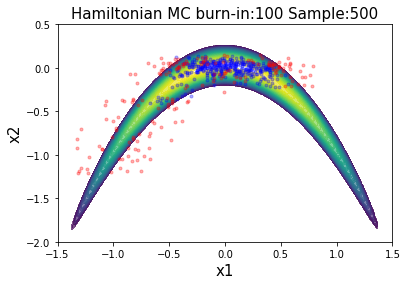

In [107]:
accepted = np.array(accepted)
rejected = np.array(rejected)

plt.title('Hamiltonian MC burn-in:100 Sample:500',fontsize = 15)
plt.plot(accepted[:,0],accepted[:,1],'b.',label = 'accepted',alpha = 0.3)
plt.plot(rejected[:,0],rejected[:,1],'r.',label = 'rejected',alpha = 0.3)
draw_post()

In [95]:
for beta in np.arange(0.1,1,0.01):
    accepted,rejected = run_chain()
    print(beta)
    print('acceptance rate = %0.1f%%' % (100*np.shape(accepted)[0]/number_of_steps))
    accepted = np.array(accepted)

0.1
acceptance rate = 75.0%
0.11
acceptance rate = 75.6%
0.12
acceptance rate = 76.0%
0.13
acceptance rate = 75.0%
0.13999999999999999
acceptance rate = 77.6%
0.14999999999999997
acceptance rate = 70.4%
0.15999999999999998
acceptance rate = 77.4%
0.16999999999999998
acceptance rate = 70.2%
0.17999999999999997
acceptance rate = 73.6%
0.18999999999999995
acceptance rate = 72.2%
0.19999999999999996
acceptance rate = 74.4%
0.20999999999999996
acceptance rate = 77.6%
0.21999999999999995
acceptance rate = 74.6%
0.22999999999999995
acceptance rate = 69.2%
0.23999999999999994
acceptance rate = 77.4%
0.24999999999999992
acceptance rate = 75.6%
0.2599999999999999
acceptance rate = 72.2%
0.2699999999999999
acceptance rate = 76.4%
0.2799999999999999
acceptance rate = 75.8%
0.2899999999999999
acceptance rate = 78.6%
0.29999999999999993
acceptance rate = 72.0%
0.30999999999999994
acceptance rate = 75.2%
0.3199999999999999
acceptance rate = 75.4%
0.32999999999999985
acceptance rate = 74.2%
0.33999999

### Tascks: 
1.  make a plot of the true density
2.  Create a gempy model, better with gravity


Likelihood

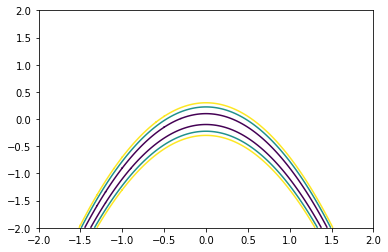

In [30]:
s = 0.01  # Try s=1, 0.25, 0.1, or 0.05
X = np.arange(-2, 2+s, s)   #Could use linspace instead if dividing
Y = np.arange(-2, 2.+s, s)   #evenly instead of stepping...

#Create the mesh grid(s) for all X/Y combos.
X, Y = np.meshgrid(X, Y)

Z =  (Y+X*X)**2

plt.contour(X,Y,Z,[0.01,0.05,0.09])

Prior

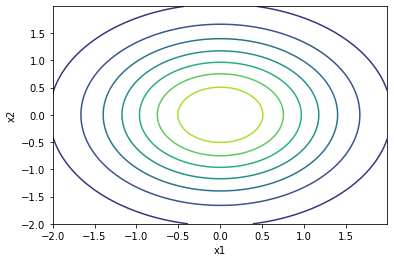

In [31]:
def plot_Prior():
    x, y = np.mgrid[-2:2:.01, -2:2:.01]
    pos = np.empty(x.shape + (2,)) 
    pos[:, :, 0] = x; pos[:, :, 1] = y
    rv = multivariate_normal([0, 0], [[1, 0], [0, 1]])
    plt.contour(x, y, rv.pdf(pos))
    plt.xlabel("x1")
    plt.ylabel("x2")
plot_Prior()

Try again put them in a inference problem

In [113]:
c = 0 # mean of observations
N = 100 # number of observation data
sigma2y = 1 # standard deviation of observation data
## generate the observation data
y_ = np.random.normal(loc =c, scale = sigma2y, size = N)
D = tf.convert_to_tensor(y_,dtype = tf.float32)

def joint_post_prob(D,theta1,theta2):
    # define random variables prior
    mvn = tfd.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    z = tf.stack([theta1, theta2], axis=-1)
    # define likelihood
    y = tfd.Normal(loc = tf.add(theta2,tf.pow(theta1,2.)), scale = sigma2y)
    # return the posterior probability
    return (tf.exp(mvn.prob(tf.squeeze(z))
           +tf.reduce_sum(y.prob(D))))

In [114]:
# y = tfd.Normal(loc = tf.add(theta2,tf.pow(theta1,2.)), scale = sigma2y)
# tf.reduce_prod(y.prob(D))

In [115]:
x, y = np.mgrid[-2:2:.01, -2:2:.01]
pos = np.empty(x.shape + (2,),dtype = np.float32) 
pos[:, :, 0] = x; pos[:, :, 1] = y

post = np.empty(x.shape)

for i in range(400):
    for j in range(400):
        post[i][j] = joint_post_prob(D,pos[i][j][0],pos[i][j][1])

Text(0, 0.5, 'x2')

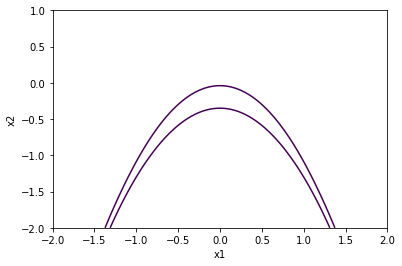

In [116]:
plt.contour(x, y, post,[joint_post_prob(D,0.,-0.35)])
plt.xlim(-2,2)
plt.ylim(-2,1)
plt.xlabel("x1")
plt.ylabel("x2")

#### make a function to plot the true density

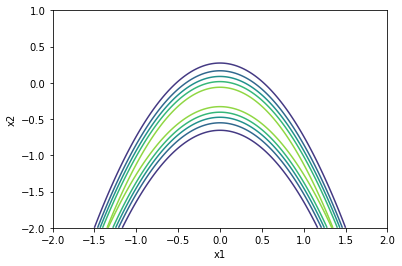

In [117]:
def plot_truepost():
    plt.contour(x, y, post)
    plt.xlim(-2,2)
    plt.ylim(-2,1)
    plt.xlabel("x1")
    plt.ylabel("x2")
plot_truepost()

likelihood

In [102]:
c = 0 # mean of observations
N = 100 # number of observation data
sigma2y = 1 # standard deviation of observation data
## generate the observation data
y_ = np.random.normal(loc =c, scale = sigma2y, size = N)
D = tf.convert_to_tensor(y_,dtype = tf.float32)

def likelihood_prob(y,theta1,theta2):
    # define random variables prior
    # define likelihood
    y = tfd.Normal(loc = tf.add(theta2,tf.pow(theta1,2.)), scale = sigma2y)

    return(y.prob(D))

In [104]:
# def multivariate_normal(x, d, mean, covariance):
#     """pdf of the multivariate normal distribution."""
#     x_m = x - mean
#     return (1. / (np.sqrt((2 * np.pi)**d * np.linalg.det(covariance))) * 
#             np.exp(-(np.linalg.solve(covariance, x_m).T.dot(x_m)) / 2))

In [ ]:
def likelihood(mu,sigma,x):
    

In [106]:
likelihood_prob(D,-1.,-1.)

<tf.Tensor: id=50688279, shape=(100,), dtype=float32, numpy=
array([0.11852656, 0.35082045, 0.27916637, 0.3175398 , 0.24357706,
       0.04958992, 0.39865258, 0.3373914 , 0.09527408, 0.30577326,
       0.31244272, 0.38152945, 0.21731788, 0.39882207, 0.28131896,
       0.2559665 , 0.396823  , 0.22954656, 0.38699   , 0.33161986,
       0.28043038, 0.15645514, 0.11792156, 0.25640616, 0.32087597,
       0.38999292, 0.33335066, 0.38605025, 0.35875905, 0.36812472,
       0.24894464, 0.14426139, 0.01804098, 0.09469493, 0.3949512 ,
       0.07429725, 0.37448597, 0.35599464, 0.35783136, 0.39716896,
       0.24605526, 0.26648703, 0.28921586, 0.07252827, 0.33239573,
       0.10574658, 0.04206104, 0.07356273, 0.05766997, 0.39133456,
       0.39744973, 0.14571816, 0.25787392, 0.15151331, 0.27348062,
       0.39223272, 0.37632185, 0.3988246 , 0.17588976, 0.2694407 ,
       0.36813956, 0.3989237 , 0.07935382, 0.2891691 , 0.3915648 ,
       0.17196114, 0.24164866, 0.3337811 , 0.28613952, 0.07877778,
 

In [43]:
x, y = np.mgrid[-2:2:.01, -2:2:.01]
pos = np.empty(x.shape + (2,),dtype = np.float32) 
pos[:, :, 0] = x; pos[:, :, 1] = y
likelihood = np.empty(x.shape)
for i in range(400):
    for j in range(400):
        likelihood[i][j] = likelihood_prob(D,pos[i][j][0],pos[i][j][1])

Text(0, 0.5, 'x2')

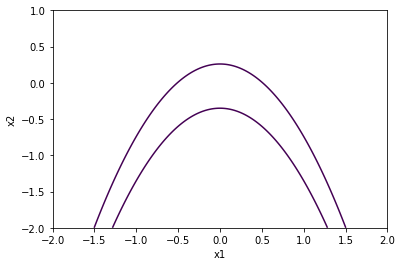

In [44]:
plt.contour(x, y, likelihood,[likelihood_prob(D,0.,-0.35).numpy()])
plt.xlim(-2,2)
plt.ylim(-2,1)
plt.xlabel("x1")
plt.ylabel("x2")
    

Prior

In [45]:
c = 0 # mean of observations
N = 100 # number of observation data
sigma2y = 1 # standard deviation of observation data
## generate the observation data
y_ = np.random.normal(loc =c, scale = sigma2y, size = N)
D = tf.convert_to_tensor(y_,dtype = tf.float32)

def prior_prob(y,theta1,theta2):
    # define random variables prior
    mvn = tfd.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    z = tf.stack([theta1, theta2], axis=-1)
    return(mvn.prob(tf.squeeze(z)))

x, y = np.mgrid[-2:2:.01, -2:2:.01]
pos = np.empty(x.shape + (2,),dtype = np.float32) 
pos[:, :, 0] = x; pos[:, :, 1] = y

prior = np.empty(x.shape)

for i in range(400):
    for j in range(400):
        prior[i][j] = prior_prob(D,pos[i][j][0],pos[i][j][1])

Text(0, 0.5, 'x2')

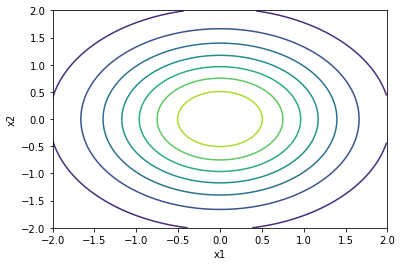

In [46]:
plt.contour(x, y, prior)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.xlabel("x1")
plt.ylabel("x2")

Let's add more observations, we shall expect broader extension

In [47]:
c = 0 # mean of observations
N = 1000 # number of observation data
sigma2y = 1 # standard deviation of observation data
## generate the observation data
y_ = np.random.normal(loc =c, scale = sigma2y, size = N)
D = tf.convert_to_tensor(y_,dtype = tf.float32)

def joint_prob(y,theta1,theta2):
    # define random variables prior
    mvn = tfd.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    z = tf.stack([theta1, theta2], axis=-1)
    # define likelihood
    y = tfd.Normal(loc = tf.add(theta2,tf.pow(theta1,2.)), scale = sigma2y)
    # return the posterior probability
    return(mvn.prob(tf.squeeze(z))
          +tf.reduce_sum(y.prob(D)))

x, y = np.mgrid[-2:2:.01, -2:2:.01]
pos = np.empty(x.shape + (2,),dtype = np.float32) 
pos[:, :, 0] = x; pos[:, :, 1] = y

pdf_1 = np.empty(x.shape)

for i in range(400):
    for j in range(400):
        pdf_1[i][j] = joint_prob(D,pos[i][j][0],pos[i][j][1])

Text(0, 0.5, 'x2')

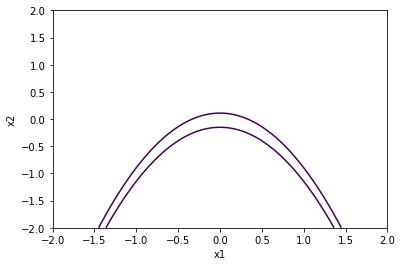

In [48]:
plt.contour(x, y, pdf_1,[joint_prob(D,0.1,0.1).numpy()])
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.xlabel("x1")
plt.ylabel("x2")

Plot the results together

In [86]:
likelihood_prob(D,-0.5,-0.35).numpy()

inf

/Users/zhouji/anaconda3/envs/Bayes/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: No contour levels were found within the data range.
  """
/Users/zhouji/anaconda3/envs/Bayes/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: No contour levels were found within the data range.
  if __name__ == '__main__':


Text(0.5, 1.0, '(c) Posterior')

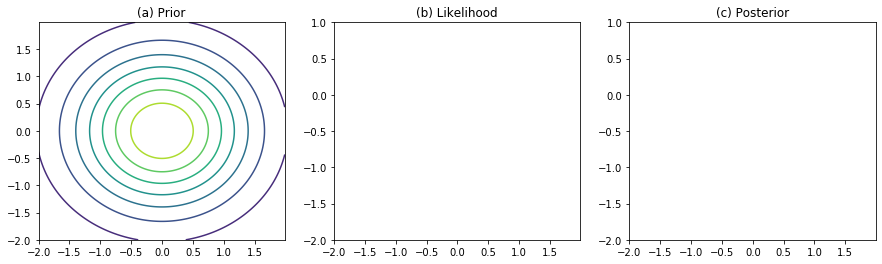

In [88]:
fig, ax = plt.subplots(1, 3,figsize=(15,4))
ax[0].contour(x, y, prior)
ax[0].set_title('(a) Prior')

ax[1].contour(x, y, likelihood,[likelihood_prob(D,0.,-0.35).numpy()])
ax[1].set_ylim(-2,1)
ax[1].set_title('(b) Likelihood')

ax[2].contour(x, y, post,[joint_post_prob(D,0.,-0.35)])
ax[2].set_ylim(-2,1)
ax[2].set_title('(c) Posterior')

Text(0.5, 1.0, '(c) Posterior')

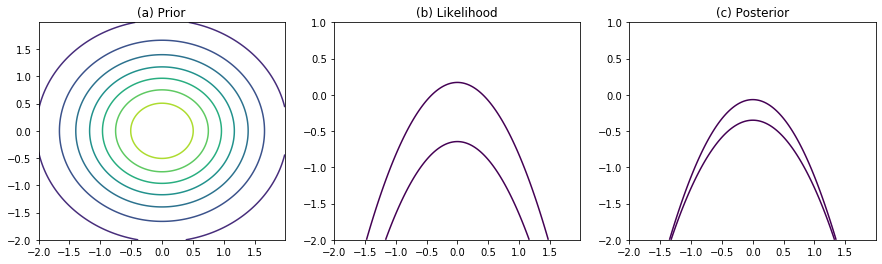

In [318]:
fig, ax = plt.subplots(1, 3,figsize=(15,4))
ax[0].contour(x, y, prior)
ax[0].set_title('(a) Prior')

ax[1].contour(x, y, likelihood,[likelihood_prob(D,0.,-0.35).numpy()])
ax[1].set_ylim(-2,1)
ax[1].set_title('(b) Likelihood')

ax[2].contour(x, y, post,[joint_post_prob(D,0.,-0.35)])
ax[2].set_ylim(-2,1)
ax[2].set_title('(c) Posterior')

(a) Prior, (b) likelihood and (c) posterior for the warped bivariate Gaussian distribution with n=100 values generated from the likelihood with parameter settings $\sigma_y$,$\sigma$ = 11: as the sample size increases and the prior becomes more diffuse, the posterior becomes less identifiable and the ridge in the posterior becomes stronger 

In [87]:
def multivariate_normal(x, d, mean, covariance):
    """pdf of the multivariate normal distribution."""
    x_m = x - mean
    return (1. / (np.sqrt((2 * np.pi)**d * np.linalg.det(covariance))) * 
            np.exp(-(np.linalg.solve(covariance, x_m).T.dot(x_m)) / 2))

In [143]:
c = 0 # mean of observations
N = 100 # number of observation data
sigma2y = 1 # standard deviation of observation data
## generate the observation data
y_ = np.random.normal(loc =c, scale = sigma2y, size = N)
D = tf.convert_to_tensor(y_,dtype = tf.float32)

def joint_post_prob(D,theta1,theta2):
    # define random variables prior
    mvn = tfd.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    z = tf.stack([theta1, theta2], axis=-1)
    # define likelihood
    y = tfd.Normal(loc = tf.add(theta2,tf.pow(theta1,2.)), scale = sigma2y)
    # return the posterior probability
    return (mvn.log_prob(tf.squeeze(z))
           +tf.reduce_sum(y.log_prob(D)))

In [8]:
num_results = 5000
burnin = 1000

initial_chain_state = [
    -0. * tf.ones([], dtype=tf.float32, name="init_t1"),
    -0. * tf.ones([], dtype=tf.float32, name="init_t2")
]

unnormalized_posterior_log_prob = lambda *args: joint_log_prob(y_, *args)

samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        step_size = 0.01,
        num_leapfrog_steps = 5),
    num_burnin_steps=burnin,
    num_steps_between_results=1,  # Thinning.
    parallel_iterations=1)

samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

x1 = samples[:,0]
y1 = samples[:,1]

x_accepted = []
y_accepted =[]

/Users/zhouji/.local/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


Acceptance rate: 98.7%


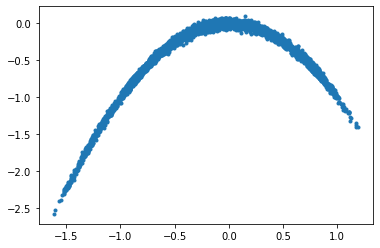

In [9]:
for i in range(accepted.shape[0]):
    if accepted[i-1]==True:
        x_accepted = np.append(x_accepted,samples[i-1,0])
        y_accepted = np.append(y_accepted,samples[i-1,1])
# f,(ax1,ax2) = plt.subplots(2,1,sharex =True, sharey = True)

# sns.kdeplot(x_accepted,y_accepted,ax=ax1)
plt.plot(x_accepted,y_accepted,'.')
# plot_true()

print('Acceptance rate: %0.1f%%' % (100*(x_accepted.shape[0]/num_results)))
